In [1]:
from datetime import timedelta
from matplotlib import pyplot as plt
                      
# !pip install "roboquant[yahoo]"
import roboquant as rq

# Feed
In order to run a strategy, we first need some data. In roboquant, data is provided by a `Feed`. 

In this example we'll use market data from Yahoo Finance.

In [2]:
feed = rq.feeds.YahooFeed("TSLA", "AAPL", "F", "JPM", start_date="2010-01-01")

It is always good to inspect the data that we planning to use. So we plot the prices for the symbols in the feed.

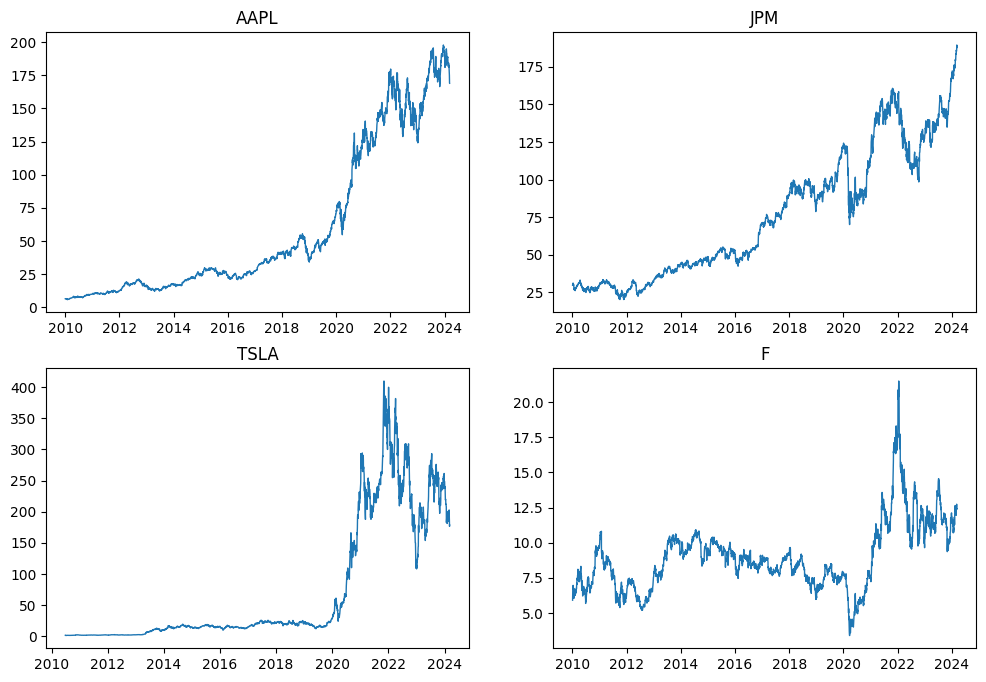

In [3]:
_, axs = plt.subplots(2,2, figsize=(12, 8))

axs = axs.flatten()
for ax, symbol in zip(axs, feed.symbols):
    feed.plot(ax, symbol, linewidth=1)

# Standard back-test

We start with a simple backtest that will run once over all the available data in the feed. We'll also collect some P&L metrics so we have something to plot.

As our strategy we'll use the included EMA (Exponential Moving Average) crossover with its default values.

In [4]:
strategy = rq.strategies.EMACrossover()
journal =  rq.journals.MetricsJournal.pnl()
rq.run(feed, strategy, journal = journal)

buying power : 1_538_839.21
equity       : 1_741_510.97
positions    : 594@JPM, 7339@F
open orders  : none
last update  : 2024-03-07 05:00:00+00:00

We can now plot the captured equity values to see how we have done. 

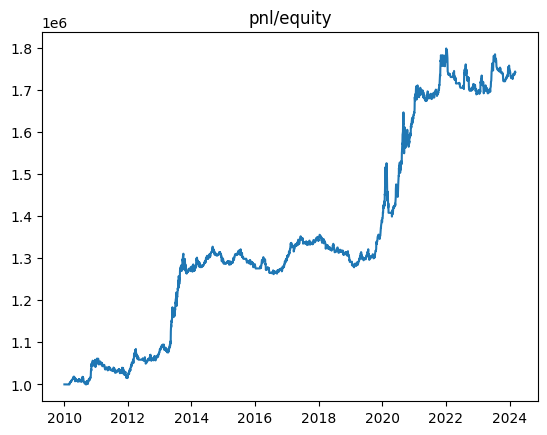

In [5]:
journal.plot(plt, "pnl/equity")

Instead of a single backtest, we can also run a walk-forward.

We split the overall timeframe of the feed into 4 equal parts and run our backtest in a loop over each part.

At the end of each iteration we plot the equity. Since we don't call a `plt.show()` between the iterations, the results will be plotted on the same chart.

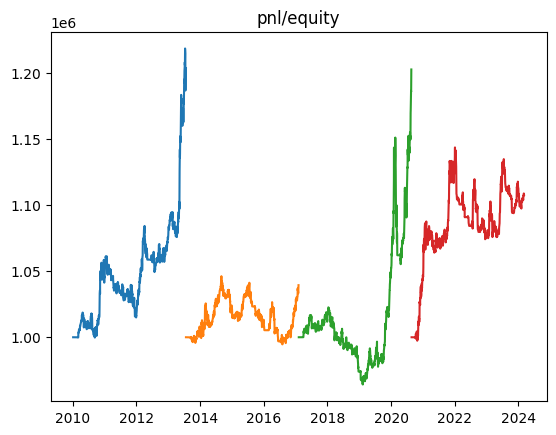

In [6]:
def run_and_plot_equity(timeframe, **kwargs):
    strategy = rq.strategies.EMACrossover()
    journal =  rq.journals.MetricsJournal.pnl()
    rq.run(feed, strategy, journal = journal, timeframe = timeframe)
    journal.plot(plt, "pnl/equity", **kwargs) 
  
for timeframe in feed.timeframe().split(4):
    run_and_plot_equity(timeframe)

We can even take it one step further, and run a Monte Carlo type of simulation over many more timeframes.

We'll sample 200 timeframes, each of a 2-year period. And then we run our backtest again over each timeframe.

Notice that when we plot the equity this time we provide `plot_x=False`. This will result in each run being plottted a sequence of values and not in a timeline. 

We can now nicely compare the variance of our runs and might better understand the possible outcomes. 

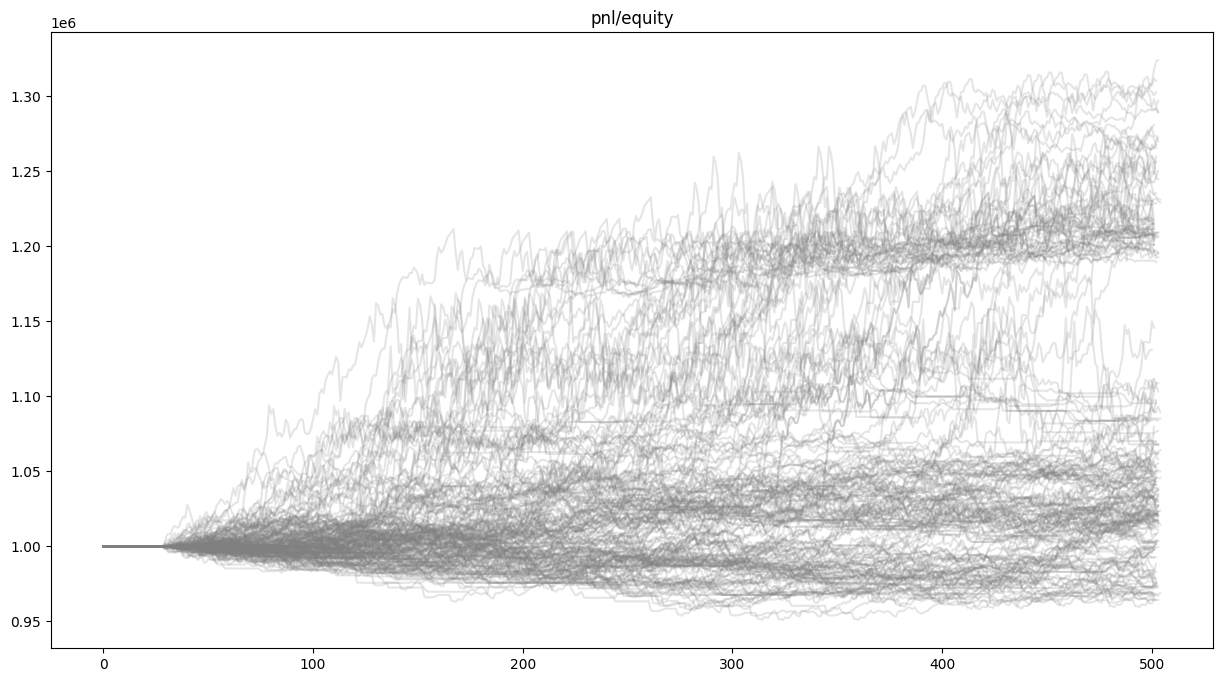

In [7]:
two_year = timedelta(days=365*2)

# sample 200 timeframes, each of two-year length
timeframes = feed.timeframe().sample(two_year, 200)

plt.figure(figsize=(15, 8))

for timeframe in timeframes:
    run_and_plot_equity(timeframe, plot_x=False, color="grey", alpha=0.2)

Now lets plot all the metrics we captured during the run

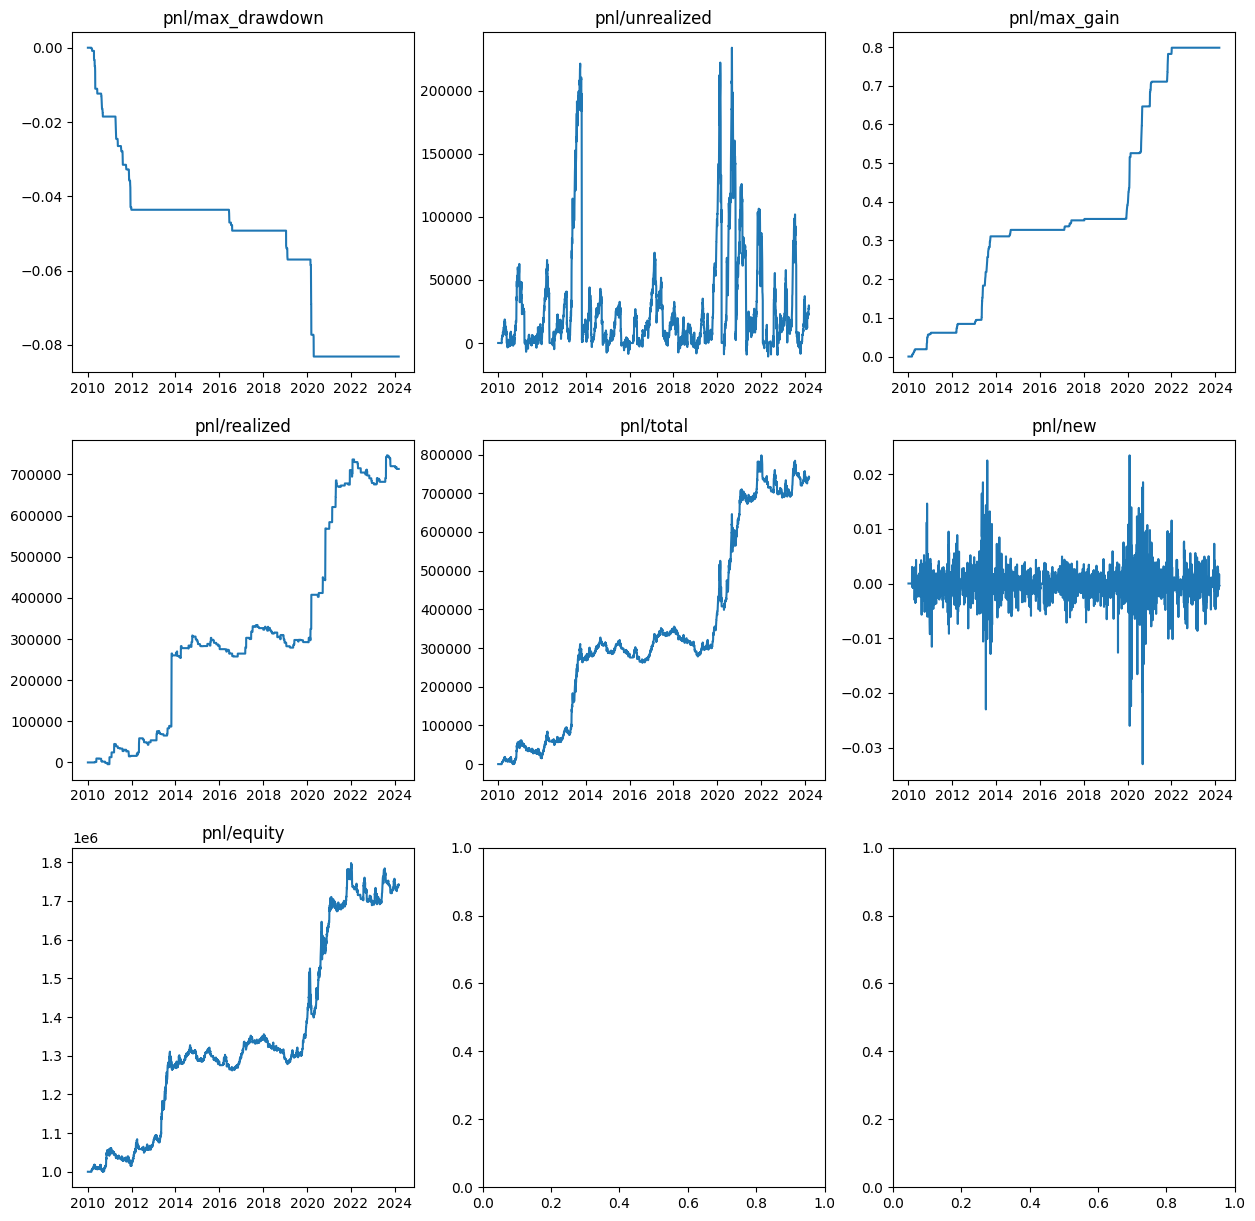

In [8]:
metric_names = journal.get_metric_names()
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for ax, metric_name in zip(axs, metric_names):
    journal.plot(ax, metric_name)